In [1]:
configuration = {"Case": 'Advection',
                 "Field": 'u',
                 "Type": 'U-Net',
                 "Epochs": 100,
                 "Batch Size": 50,
                 "Optimizer": 'Adam',
                 "Learning Rate": 0.001,
                 "Scheduler Step": 100,
                 "Scheduler Gamma": 0.5,
                 "Activation": 'Tanh',
                 "Normalisation Strategy": 'None',
                 "T_in": 20,    
                 "T_out": 30,
                 "Step": 30,
                 "Width": 32, 
                 "Variables":1, 
                 "Noise":0.0, 
                 "Loss Function": 'MSE',
                 }

from simvue import Run
run = Run(mode='disabled')
run.init(folder="/Residual_UQ", tags=['Conformal Prediction', 'Advection', 'U-Net'], metadata=configuration)
run_name = 'mean'
print(run_name)

mean


In [2]:
import os 
import numpy as np
from tqdm import tqdm 
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from matplotlib import cm 

import operator
from functools import reduce
from functools import partial
from collections import OrderedDict

import time 
from timeit import default_timer
from tqdm import tqdm 

from collections import OrderedDict
from utils import *
import platform
torch.manual_seed(0)
np.random.seed(0)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_dtype(torch.float32)

In [3]:
from DataGen import *
u = torch.tensor(u_sol, dtype=torch.float32)
# u = u.permute(0, 2, 3, 1) #only for FNO
x_disc = x
t_disc = t

100%|██████████| 100/100 [00:00<00:00, 103.33it/s]


In [4]:
ntrain = 80
ntest = 20
S = 200 #Grid Size

width = configuration['Width']
output_size = configuration['Step']

batch_size = configuration['Batch Size']
batch_size2 = batch_size

t1 = default_timer()

T_in = configuration['T_in']
T = T_out = configuration['T_out']
step = configuration['Step']
################################################################
# load data
################################################################

train_a = u[:ntrain,:T_in,:]
train_u = u[:ntrain,T_in:T_out+T_in,:]

test_a = u[-ntest:,:T_in, :]
test_u = u[-ntest:,T_in:T_out+T_in,:]

print(train_u.shape)
print(test_u.shape)

torch.Size([80, 30, 200])
torch.Size([20, 30, 200])


In [5]:
#Normalising the train and test datasets with the preferred normalisation. 

norm_strategy = configuration['Normalisation Strategy']

if norm_strategy == 'Min-Max':
    a_normalizer = MinMax_Normalizer(train_a)
    y_normalizer = MinMax_Normalizer(train_u)

if norm_strategy == 'Range':
    a_normalizer = RangeNormalizer(train_a)
    y_normalizer = RangeNormalizer(train_u)

if norm_strategy == 'Gaussian':
    a_normalizer = GaussianNormalizer(train_a)
    y_normalizer = GaussianNormalizer(train_u)

if norm_strategy == 'None':
    a_normalizer = Identity(train_a)
    y_normalizer = Identity(train_u)

train_a = a_normalizer.encode(train_a)
test_a = a_normalizer.encode(test_a)

train_u = y_normalizer.encode(train_u)
test_u_encoded = y_normalizer.encode(test_u)

In [6]:
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_a, train_u), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a, test_u_encoded), batch_size=batch_size, shuffle=False)

t2 = default_timer()
print('preprocessing finished, time used:', t2-t1)

preprocessing finished, time used: 0.015189459000000127


In [7]:
################################################################
# training and evaluation
################################################################

model = UNet1d(T_in, step, 32)
# model = UNet1d_dropout(T_in, step, 32)
model.to(device)
model = model.float()
run.update_metadata({'Number of Params': int(model.count_params())})

print("Number of model params : " + str(model.count_params()))

optimizer = torch.optim.Adam(model.parameters(), lr=configuration['Learning Rate'], weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=configuration['Scheduler Step'], gamma=configuration['Scheduler Gamma'])

# myloss = LpLoss(size_average=False)
myloss = torch.nn.MSELoss()

Number of model params : 2841662


In [8]:
epochs = configuration['Epochs']

if torch.cuda.is_available():
    y_normalizer.cuda()
    
start_time = time.time()
for ep in tqdm(range(epochs)):
    model.train()
    t1 = default_timer()
    train_l2_step = 0
    train_l2_full = 0
    for xx, yy in train_loader:
        loss = 0
        xx = xx.to(device)
        yy = yy.to(device)
        # xx = additive_noise(xx)

        for t in range(0, T, step):
            y = yy[:, t:t + step, :]
            im = model(xx)
            loss += myloss(im.reshape(batch_size, -1), y.reshape(batch_size, -1))

            if t == 0:
                pred = im
            else:
                pred = torch.cat((pred, im), 1)

            xx = torch.cat((xx[:, step:, :], im), dim=1)

        train_l2_step += loss.item()
        l2_full = myloss(pred.reshape(batch_size, -1), yy.reshape(batch_size, -1))
        train_l2_full += l2_full.item()

        optimizer.zero_grad()
        loss.backward()
        # l2_full.backward()
        optimizer.step()

    test_l2_step = 0
    test_l2_full = 0
    with torch.no_grad():
        for xx, yy in test_loader:
            loss = 0
            xx = xx.to(device)
            yy = yy.to(device)

            for t in range(0, T, step):
                y = yy[:, t:t + step, :]
                im = model(xx)
                loss += myloss(im.reshape(batch_size, -1), y.reshape(batch_size, -1))

                if t == 0:
                    pred = im
                else:
                    pred = torch.cat((pred, im), 1)

                xx = torch.cat((xx[:, step:, :], im), dim=1)

            
            test_l2_step += loss.item()
            test_l2_full += myloss(pred.reshape(batch_size, -1), yy.reshape(batch_size, -1)).item()


    t2 = default_timer()
    scheduler.step()
    
    train_loss = train_l2_full / ntrain
    test_loss = test_l2_full / ntest
    
    print('Epochs: %d, Time: %.2f, Train Loss per step: %.3e, Train Loss: %.3e, Test Loss per step: %.3e, Test Loss: %.3e' % (ep, t2 - t1, train_l2_step / ntrain / (T / step), train_loss, test_l2_step / ntest / (T / step), test_loss))
    

    run.log_metrics({'Train Loss': train_loss, 
                    'Test Loss': test_loss})
    
train_time = time.time() - start_time

  1%|          | 1/100 [00:01<02:01,  1.22s/it]

Epochs: 0, Time: 1.22, Train Loss per step: 4.296e-03, Train Loss: 4.296e-03, Test Loss per step: 5.940e-03, Test Loss: 5.940e-03


  2%|▏         | 2/100 [00:02<01:54,  1.17s/it]

Epochs: 1, Time: 1.13, Train Loss per step: 2.693e-03, Train Loss: 2.693e-03, Test Loss per step: 4.070e-03, Test Loss: 4.070e-03


  3%|▎         | 3/100 [00:03<01:52,  1.15s/it]

Epochs: 2, Time: 1.14, Train Loss per step: 1.935e-03, Train Loss: 1.935e-03, Test Loss per step: 3.255e-03, Test Loss: 3.255e-03


  4%|▍         | 4/100 [00:04<01:49,  1.14s/it]

Epochs: 3, Time: 1.12, Train Loss per step: 1.560e-03, Train Loss: 1.560e-03, Test Loss per step: 2.718e-03, Test Loss: 2.718e-03


  5%|▌         | 5/100 [00:05<01:49,  1.16s/it]

Epochs: 4, Time: 1.19, Train Loss per step: 1.308e-03, Train Loss: 1.308e-03, Test Loss per step: 2.347e-03, Test Loss: 2.347e-03


  6%|▌         | 6/100 [00:06<01:48,  1.16s/it]

Epochs: 5, Time: 1.15, Train Loss per step: 1.131e-03, Train Loss: 1.131e-03, Test Loss per step: 2.062e-03, Test Loss: 2.062e-03


  7%|▋         | 7/100 [00:08<01:46,  1.15s/it]

Epochs: 6, Time: 1.12, Train Loss per step: 9.939e-04, Train Loss: 9.939e-04, Test Loss per step: 1.828e-03, Test Loss: 1.828e-03


  8%|▊         | 8/100 [00:09<01:47,  1.17s/it]

Epochs: 7, Time: 1.23, Train Loss per step: 8.876e-04, Train Loss: 8.876e-04, Test Loss per step: 1.634e-03, Test Loss: 1.634e-03


  9%|▉         | 9/100 [00:10<01:46,  1.17s/it]

Epochs: 8, Time: 1.16, Train Loss per step: 7.982e-04, Train Loss: 7.982e-04, Test Loss per step: 1.468e-03, Test Loss: 1.468e-03


 10%|█         | 10/100 [00:11<01:43,  1.15s/it]

Epochs: 9, Time: 1.12, Train Loss per step: 7.290e-04, Train Loss: 7.290e-04, Test Loss per step: 1.339e-03, Test Loss: 1.339e-03


 11%|█         | 11/100 [00:12<01:42,  1.15s/it]

Epochs: 10, Time: 1.15, Train Loss per step: 6.636e-04, Train Loss: 6.636e-04, Test Loss per step: 1.224e-03, Test Loss: 1.224e-03


 12%|█▏        | 12/100 [00:13<01:41,  1.15s/it]

Epochs: 11, Time: 1.15, Train Loss per step: 6.033e-04, Train Loss: 6.033e-04, Test Loss per step: 1.116e-03, Test Loss: 1.116e-03


 13%|█▎        | 13/100 [00:15<01:40,  1.16s/it]

Epochs: 12, Time: 1.17, Train Loss per step: 5.641e-04, Train Loss: 5.641e-04, Test Loss per step: 1.040e-03, Test Loss: 1.040e-03


 14%|█▍        | 14/100 [00:16<01:39,  1.16s/it]

Epochs: 13, Time: 1.17, Train Loss per step: 5.147e-04, Train Loss: 5.147e-04, Test Loss per step: 9.704e-04, Test Loss: 9.704e-04


 15%|█▌        | 15/100 [00:17<01:38,  1.16s/it]

Epochs: 14, Time: 1.14, Train Loss per step: 4.743e-04, Train Loss: 4.743e-04, Test Loss per step: 8.813e-04, Test Loss: 8.813e-04


 16%|█▌        | 16/100 [00:18<01:36,  1.15s/it]

Epochs: 15, Time: 1.13, Train Loss per step: 4.377e-04, Train Loss: 4.377e-04, Test Loss per step: 8.144e-04, Test Loss: 8.144e-04


 17%|█▋        | 17/100 [00:19<01:35,  1.15s/it]

Epochs: 16, Time: 1.14, Train Loss per step: 4.053e-04, Train Loss: 4.053e-04, Test Loss per step: 7.660e-04, Test Loss: 7.660e-04


 18%|█▊        | 18/100 [00:20<01:33,  1.14s/it]

Epochs: 17, Time: 1.13, Train Loss per step: 3.750e-04, Train Loss: 3.750e-04, Test Loss per step: 6.994e-04, Test Loss: 6.994e-04


 19%|█▉        | 19/100 [00:21<01:33,  1.15s/it]

Epochs: 18, Time: 1.18, Train Loss per step: 3.475e-04, Train Loss: 3.475e-04, Test Loss per step: 6.430e-04, Test Loss: 6.430e-04


 20%|██        | 20/100 [00:23<01:31,  1.15s/it]

Epochs: 19, Time: 1.13, Train Loss per step: 3.227e-04, Train Loss: 3.227e-04, Test Loss per step: 6.040e-04, Test Loss: 6.040e-04


 21%|██        | 21/100 [00:24<01:29,  1.14s/it]

Epochs: 20, Time: 1.11, Train Loss per step: 2.997e-04, Train Loss: 2.997e-04, Test Loss per step: 5.665e-04, Test Loss: 5.665e-04


 22%|██▏       | 22/100 [00:25<01:29,  1.14s/it]

Epochs: 21, Time: 1.16, Train Loss per step: 2.802e-04, Train Loss: 2.802e-04, Test Loss per step: 5.248e-04, Test Loss: 5.248e-04


 23%|██▎       | 23/100 [00:26<01:27,  1.14s/it]

Epochs: 22, Time: 1.13, Train Loss per step: 2.606e-04, Train Loss: 2.606e-04, Test Loss per step: 5.091e-04, Test Loss: 5.091e-04


 24%|██▍       | 24/100 [00:27<01:26,  1.14s/it]

Epochs: 23, Time: 1.13, Train Loss per step: 2.453e-04, Train Loss: 2.453e-04, Test Loss per step: 4.599e-04, Test Loss: 4.599e-04


 25%|██▌       | 25/100 [00:28<01:25,  1.15s/it]

Epochs: 24, Time: 1.16, Train Loss per step: 2.322e-04, Train Loss: 2.322e-04, Test Loss per step: 4.323e-04, Test Loss: 4.323e-04


 26%|██▌       | 26/100 [00:29<01:25,  1.16s/it]

Epochs: 25, Time: 1.19, Train Loss per step: 2.161e-04, Train Loss: 2.161e-04, Test Loss per step: 4.058e-04, Test Loss: 4.058e-04


 27%|██▋       | 27/100 [00:31<01:25,  1.17s/it]

Epochs: 26, Time: 1.18, Train Loss per step: 2.048e-04, Train Loss: 2.048e-04, Test Loss per step: 4.093e-04, Test Loss: 4.093e-04


 28%|██▊       | 28/100 [00:32<01:23,  1.16s/it]

Epochs: 27, Time: 1.15, Train Loss per step: 1.932e-04, Train Loss: 1.932e-04, Test Loss per step: 3.632e-04, Test Loss: 3.632e-04


 29%|██▉       | 29/100 [00:33<01:23,  1.17s/it]

Epochs: 28, Time: 1.20, Train Loss per step: 1.882e-04, Train Loss: 1.882e-04, Test Loss per step: 3.781e-04, Test Loss: 3.781e-04


 30%|███       | 30/100 [00:34<01:21,  1.17s/it]

Epochs: 29, Time: 1.15, Train Loss per step: 1.778e-04, Train Loss: 1.778e-04, Test Loss per step: 3.309e-04, Test Loss: 3.309e-04


 31%|███       | 31/100 [00:35<01:20,  1.16s/it]

Epochs: 30, Time: 1.15, Train Loss per step: 1.649e-04, Train Loss: 1.649e-04, Test Loss per step: 3.058e-04, Test Loss: 3.058e-04


 32%|███▏      | 32/100 [00:36<01:18,  1.16s/it]

Epochs: 31, Time: 1.15, Train Loss per step: 1.562e-04, Train Loss: 1.562e-04, Test Loss per step: 3.309e-04, Test Loss: 3.309e-04


 33%|███▎      | 33/100 [00:38<01:17,  1.15s/it]

Epochs: 32, Time: 1.14, Train Loss per step: 1.484e-04, Train Loss: 1.484e-04, Test Loss per step: 2.705e-04, Test Loss: 2.705e-04


 34%|███▍      | 34/100 [00:39<01:16,  1.15s/it]

Epochs: 33, Time: 1.15, Train Loss per step: 1.397e-04, Train Loss: 1.397e-04, Test Loss per step: 3.303e-04, Test Loss: 3.303e-04


 35%|███▌      | 35/100 [00:40<01:14,  1.15s/it]

Epochs: 34, Time: 1.13, Train Loss per step: 1.393e-04, Train Loss: 1.393e-04, Test Loss per step: 2.591e-04, Test Loss: 2.591e-04


 36%|███▌      | 36/100 [00:41<01:13,  1.15s/it]

Epochs: 35, Time: 1.15, Train Loss per step: 1.324e-04, Train Loss: 1.324e-04, Test Loss per step: 2.344e-04, Test Loss: 2.344e-04


 37%|███▋      | 37/100 [00:42<01:12,  1.15s/it]

Epochs: 36, Time: 1.15, Train Loss per step: 1.217e-04, Train Loss: 1.217e-04, Test Loss per step: 2.389e-04, Test Loss: 2.389e-04


 38%|███▊      | 38/100 [00:43<01:11,  1.15s/it]

Epochs: 37, Time: 1.17, Train Loss per step: 1.144e-04, Train Loss: 1.144e-04, Test Loss per step: 2.280e-04, Test Loss: 2.280e-04


 39%|███▉      | 39/100 [00:45<01:10,  1.15s/it]

Epochs: 38, Time: 1.15, Train Loss per step: 1.070e-04, Train Loss: 1.070e-04, Test Loss per step: 2.100e-04, Test Loss: 2.100e-04


 40%|████      | 40/100 [00:46<01:09,  1.16s/it]

Epochs: 39, Time: 1.17, Train Loss per step: 1.049e-04, Train Loss: 1.049e-04, Test Loss per step: 2.050e-04, Test Loss: 2.050e-04


 41%|████      | 41/100 [00:47<01:08,  1.16s/it]

Epochs: 40, Time: 1.16, Train Loss per step: 1.001e-04, Train Loss: 1.001e-04, Test Loss per step: 2.130e-04, Test Loss: 2.130e-04


 42%|████▏     | 42/100 [00:48<01:07,  1.16s/it]

Epochs: 41, Time: 1.16, Train Loss per step: 9.857e-05, Train Loss: 9.857e-05, Test Loss per step: 1.954e-04, Test Loss: 1.954e-04


 43%|████▎     | 43/100 [00:49<01:06,  1.16s/it]

Epochs: 42, Time: 1.16, Train Loss per step: 9.131e-05, Train Loss: 9.131e-05, Test Loss per step: 1.770e-04, Test Loss: 1.770e-04


 44%|████▍     | 44/100 [00:50<01:04,  1.16s/it]

Epochs: 43, Time: 1.15, Train Loss per step: 8.489e-05, Train Loss: 8.489e-05, Test Loss per step: 1.689e-04, Test Loss: 1.689e-04


 45%|████▌     | 45/100 [00:51<01:03,  1.16s/it]

Epochs: 44, Time: 1.16, Train Loss per step: 8.045e-05, Train Loss: 8.045e-05, Test Loss per step: 1.998e-04, Test Loss: 1.998e-04


 46%|████▌     | 46/100 [00:53<01:02,  1.16s/it]

Epochs: 45, Time: 1.17, Train Loss per step: 7.841e-05, Train Loss: 7.841e-05, Test Loss per step: 1.511e-04, Test Loss: 1.511e-04


 47%|████▋     | 47/100 [00:54<01:01,  1.16s/it]

Epochs: 46, Time: 1.16, Train Loss per step: 7.322e-05, Train Loss: 7.322e-05, Test Loss per step: 1.663e-04, Test Loss: 1.663e-04


 48%|████▊     | 48/100 [00:55<01:00,  1.16s/it]

Epochs: 47, Time: 1.17, Train Loss per step: 6.975e-05, Train Loss: 6.975e-05, Test Loss per step: 1.485e-04, Test Loss: 1.485e-04


 49%|████▉     | 49/100 [00:56<00:59,  1.16s/it]

Epochs: 48, Time: 1.15, Train Loss per step: 6.713e-05, Train Loss: 6.713e-05, Test Loss per step: 1.506e-04, Test Loss: 1.506e-04


 50%|█████     | 50/100 [00:57<00:57,  1.16s/it]

Epochs: 49, Time: 1.16, Train Loss per step: 6.699e-05, Train Loss: 6.699e-05, Test Loss per step: 1.792e-04, Test Loss: 1.792e-04


 51%|█████     | 51/100 [00:58<00:56,  1.16s/it]

Epochs: 50, Time: 1.16, Train Loss per step: 6.478e-05, Train Loss: 6.478e-05, Test Loss per step: 1.366e-04, Test Loss: 1.366e-04


 52%|█████▏    | 52/100 [01:00<00:55,  1.16s/it]

Epochs: 51, Time: 1.15, Train Loss per step: 6.377e-05, Train Loss: 6.377e-05, Test Loss per step: 1.342e-04, Test Loss: 1.342e-04


 53%|█████▎    | 53/100 [01:01<00:54,  1.16s/it]

Epochs: 52, Time: 1.16, Train Loss per step: 6.621e-05, Train Loss: 6.621e-05, Test Loss per step: 1.739e-04, Test Loss: 1.739e-04


 54%|█████▍    | 54/100 [01:02<00:53,  1.16s/it]

Epochs: 53, Time: 1.17, Train Loss per step: 6.384e-05, Train Loss: 6.384e-05, Test Loss per step: 1.279e-04, Test Loss: 1.279e-04


 55%|█████▌    | 55/100 [01:03<00:52,  1.16s/it]

Epochs: 54, Time: 1.17, Train Loss per step: 5.926e-05, Train Loss: 5.926e-05, Test Loss per step: 1.281e-04, Test Loss: 1.281e-04


 56%|█████▌    | 56/100 [01:04<00:51,  1.17s/it]

Epochs: 55, Time: 1.17, Train Loss per step: 5.616e-05, Train Loss: 5.616e-05, Test Loss per step: 1.442e-04, Test Loss: 1.442e-04


 57%|█████▋    | 57/100 [01:05<00:49,  1.16s/it]

Epochs: 56, Time: 1.14, Train Loss per step: 5.458e-05, Train Loss: 5.458e-05, Test Loss per step: 1.086e-04, Test Loss: 1.086e-04


 58%|█████▊    | 58/100 [01:07<00:48,  1.16s/it]

Epochs: 57, Time: 1.17, Train Loss per step: 5.152e-05, Train Loss: 5.152e-05, Test Loss per step: 1.323e-04, Test Loss: 1.323e-04


 59%|█████▉    | 59/100 [01:08<00:47,  1.17s/it]

Epochs: 58, Time: 1.18, Train Loss per step: 4.709e-05, Train Loss: 4.709e-05, Test Loss per step: 9.579e-05, Test Loss: 9.579e-05


 60%|██████    | 60/100 [01:09<00:46,  1.17s/it]

Epochs: 59, Time: 1.17, Train Loss per step: 4.850e-05, Train Loss: 4.850e-05, Test Loss per step: 1.488e-04, Test Loss: 1.488e-04


 61%|██████    | 61/100 [01:10<00:45,  1.17s/it]

Epochs: 60, Time: 1.17, Train Loss per step: 5.691e-05, Train Loss: 5.691e-05, Test Loss per step: 9.565e-05, Test Loss: 9.565e-05


 62%|██████▏   | 62/100 [01:11<00:44,  1.17s/it]

Epochs: 61, Time: 1.17, Train Loss per step: 4.427e-05, Train Loss: 4.427e-05, Test Loss per step: 1.218e-04, Test Loss: 1.218e-04


 63%|██████▎   | 63/100 [01:12<00:43,  1.17s/it]

Epochs: 62, Time: 1.17, Train Loss per step: 4.408e-05, Train Loss: 4.408e-05, Test Loss per step: 9.122e-05, Test Loss: 9.122e-05


 64%|██████▍   | 64/100 [01:14<00:42,  1.17s/it]

Epochs: 63, Time: 1.16, Train Loss per step: 4.107e-05, Train Loss: 4.107e-05, Test Loss per step: 1.064e-04, Test Loss: 1.064e-04


 65%|██████▌   | 65/100 [01:15<00:40,  1.17s/it]

Epochs: 64, Time: 1.16, Train Loss per step: 3.905e-05, Train Loss: 3.905e-05, Test Loss per step: 8.714e-05, Test Loss: 8.714e-05


 66%|██████▌   | 66/100 [01:16<00:39,  1.18s/it]

Epochs: 65, Time: 1.20, Train Loss per step: 3.938e-05, Train Loss: 3.938e-05, Test Loss per step: 9.120e-05, Test Loss: 9.120e-05


 67%|██████▋   | 67/100 [01:17<00:38,  1.18s/it]

Epochs: 66, Time: 1.18, Train Loss per step: 3.767e-05, Train Loss: 3.767e-05, Test Loss per step: 9.748e-05, Test Loss: 9.748e-05


 68%|██████▊   | 68/100 [01:18<00:37,  1.17s/it]

Epochs: 67, Time: 1.16, Train Loss per step: 3.585e-05, Train Loss: 3.585e-05, Test Loss per step: 8.098e-05, Test Loss: 8.098e-05


 69%|██████▉   | 69/100 [01:20<00:36,  1.18s/it]

Epochs: 68, Time: 1.19, Train Loss per step: 3.536e-05, Train Loss: 3.536e-05, Test Loss per step: 1.053e-04, Test Loss: 1.053e-04


 70%|███████   | 70/100 [01:21<00:35,  1.19s/it]

Epochs: 69, Time: 1.21, Train Loss per step: 3.506e-05, Train Loss: 3.506e-05, Test Loss per step: 7.634e-05, Test Loss: 7.634e-05


 71%|███████   | 71/100 [01:22<00:34,  1.19s/it]

Epochs: 70, Time: 1.18, Train Loss per step: 3.205e-05, Train Loss: 3.205e-05, Test Loss per step: 9.169e-05, Test Loss: 9.169e-05


 72%|███████▏  | 72/100 [01:23<00:32,  1.18s/it]

Epochs: 71, Time: 1.16, Train Loss per step: 3.100e-05, Train Loss: 3.100e-05, Test Loss per step: 7.461e-05, Test Loss: 7.461e-05


 73%|███████▎  | 73/100 [01:24<00:31,  1.17s/it]

Epochs: 72, Time: 1.15, Train Loss per step: 3.064e-05, Train Loss: 3.064e-05, Test Loss per step: 8.089e-05, Test Loss: 8.089e-05


 74%|███████▍  | 74/100 [01:25<00:30,  1.17s/it]

Epochs: 73, Time: 1.16, Train Loss per step: 2.997e-05, Train Loss: 2.997e-05, Test Loss per step: 7.004e-05, Test Loss: 7.004e-05


 75%|███████▌  | 75/100 [01:27<00:29,  1.17s/it]

Epochs: 74, Time: 1.17, Train Loss per step: 2.890e-05, Train Loss: 2.890e-05, Test Loss per step: 7.775e-05, Test Loss: 7.775e-05


 76%|███████▌  | 76/100 [01:28<00:28,  1.17s/it]

Epochs: 75, Time: 1.17, Train Loss per step: 3.813e-05, Train Loss: 3.813e-05, Test Loss per step: 6.179e-05, Test Loss: 6.179e-05


 77%|███████▋  | 77/100 [01:29<00:26,  1.17s/it]

Epochs: 76, Time: 1.17, Train Loss per step: 3.918e-05, Train Loss: 3.918e-05, Test Loss per step: 7.413e-05, Test Loss: 7.413e-05


 78%|███████▊  | 78/100 [01:30<00:25,  1.17s/it]

Epochs: 77, Time: 1.18, Train Loss per step: 3.435e-05, Train Loss: 3.435e-05, Test Loss per step: 8.181e-05, Test Loss: 8.181e-05


 79%|███████▉  | 79/100 [01:31<00:24,  1.17s/it]

Epochs: 78, Time: 1.17, Train Loss per step: 3.309e-05, Train Loss: 3.309e-05, Test Loss per step: 6.530e-05, Test Loss: 6.530e-05


 80%|████████  | 80/100 [01:32<00:23,  1.17s/it]

Epochs: 79, Time: 1.18, Train Loss per step: 2.946e-05, Train Loss: 2.946e-05, Test Loss per step: 1.080e-04, Test Loss: 1.080e-04


 81%|████████  | 81/100 [01:34<00:22,  1.17s/it]

Epochs: 80, Time: 1.16, Train Loss per step: 3.181e-05, Train Loss: 3.181e-05, Test Loss per step: 7.050e-05, Test Loss: 7.050e-05


 82%|████████▏ | 82/100 [01:35<00:21,  1.17s/it]

Epochs: 81, Time: 1.17, Train Loss per step: 3.893e-05, Train Loss: 3.893e-05, Test Loss per step: 7.193e-05, Test Loss: 7.193e-05


 83%|████████▎ | 83/100 [01:36<00:19,  1.17s/it]

Epochs: 82, Time: 1.18, Train Loss per step: 3.168e-05, Train Loss: 3.168e-05, Test Loss per step: 6.979e-05, Test Loss: 6.979e-05


 84%|████████▍ | 84/100 [01:37<00:18,  1.17s/it]

Epochs: 83, Time: 1.16, Train Loss per step: 2.994e-05, Train Loss: 2.994e-05, Test Loss per step: 7.722e-05, Test Loss: 7.722e-05


 85%|████████▌ | 85/100 [01:38<00:17,  1.17s/it]

Epochs: 84, Time: 1.18, Train Loss per step: 2.911e-05, Train Loss: 2.911e-05, Test Loss per step: 7.562e-05, Test Loss: 7.562e-05


 86%|████████▌ | 86/100 [01:39<00:16,  1.17s/it]

Epochs: 85, Time: 1.17, Train Loss per step: 2.750e-05, Train Loss: 2.750e-05, Test Loss per step: 6.299e-05, Test Loss: 6.299e-05


 87%|████████▋ | 87/100 [01:41<00:15,  1.17s/it]

Epochs: 86, Time: 1.16, Train Loss per step: 2.547e-05, Train Loss: 2.547e-05, Test Loss per step: 5.430e-05, Test Loss: 5.430e-05


 88%|████████▊ | 88/100 [01:42<00:13,  1.17s/it]

Epochs: 87, Time: 1.16, Train Loss per step: 2.457e-05, Train Loss: 2.457e-05, Test Loss per step: 5.732e-05, Test Loss: 5.732e-05


 89%|████████▉ | 89/100 [01:43<00:12,  1.16s/it]

Epochs: 88, Time: 1.16, Train Loss per step: 2.298e-05, Train Loss: 2.298e-05, Test Loss per step: 6.532e-05, Test Loss: 6.532e-05


 90%|█████████ | 90/100 [01:44<00:11,  1.17s/it]

Epochs: 89, Time: 1.18, Train Loss per step: 2.237e-05, Train Loss: 2.237e-05, Test Loss per step: 6.198e-05, Test Loss: 6.198e-05


 91%|█████████ | 91/100 [01:45<00:10,  1.17s/it]

Epochs: 90, Time: 1.17, Train Loss per step: 2.304e-05, Train Loss: 2.304e-05, Test Loss per step: 5.780e-05, Test Loss: 5.780e-05


 92%|█████████▏| 92/100 [01:46<00:09,  1.16s/it]

Epochs: 91, Time: 1.15, Train Loss per step: 2.042e-05, Train Loss: 2.042e-05, Test Loss per step: 5.547e-05, Test Loss: 5.547e-05


 93%|█████████▎| 93/100 [01:48<00:08,  1.17s/it]

Epochs: 92, Time: 1.17, Train Loss per step: 1.994e-05, Train Loss: 1.994e-05, Test Loss per step: 6.144e-05, Test Loss: 6.144e-05


 94%|█████████▍| 94/100 [01:49<00:06,  1.16s/it]

Epochs: 93, Time: 1.16, Train Loss per step: 2.294e-05, Train Loss: 2.294e-05, Test Loss per step: 5.352e-05, Test Loss: 5.352e-05


 95%|█████████▌| 95/100 [01:50<00:05,  1.17s/it]

Epochs: 94, Time: 1.17, Train Loss per step: 2.199e-05, Train Loss: 2.199e-05, Test Loss per step: 5.003e-05, Test Loss: 5.003e-05


 96%|█████████▌| 96/100 [01:51<00:04,  1.17s/it]

Epochs: 95, Time: 1.16, Train Loss per step: 1.959e-05, Train Loss: 1.959e-05, Test Loss per step: 4.829e-05, Test Loss: 4.829e-05


 97%|█████████▋| 97/100 [01:52<00:03,  1.17s/it]

Epochs: 96, Time: 1.17, Train Loss per step: 2.461e-05, Train Loss: 2.461e-05, Test Loss per step: 4.684e-05, Test Loss: 4.684e-05


 98%|█████████▊| 98/100 [01:53<00:02,  1.17s/it]

Epochs: 97, Time: 1.17, Train Loss per step: 2.125e-05, Train Loss: 2.125e-05, Test Loss per step: 4.732e-05, Test Loss: 4.732e-05


 99%|█████████▉| 99/100 [01:55<00:01,  1.17s/it]

Epochs: 98, Time: 1.16, Train Loss per step: 1.996e-05, Train Loss: 1.996e-05, Test Loss per step: 5.658e-05, Test Loss: 5.658e-05


100%|██████████| 100/100 [01:56<00:00,  1.16s/it]

Epochs: 99, Time: 1.16, Train Loss per step: 1.938e-05, Train Loss: 1.938e-05, Test Loss per step: 5.041e-05, Test Loss: 5.041e-05


In [9]:
# model_loc = file_loc + '/Models/Unet_CD_' + run_name + '_' + str(gamma)+ '.pth'
# torch.save(model.state_dict(),  model_loc)

In [10]:
#Testing 
batch_size = 1 
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a, test_u_encoded), batch_size=1, shuffle=False)

pred_set = torch.zeros(test_u.shape)
index = 0
with torch.no_grad():
    for xx, yy in tqdm(test_loader):
        t1 = default_timer()
        loss = 0
        xx, yy = xx.to(device), yy.to(device)
        t1 = default_timer()
        # xx = additive_noise(xx)
        for t in range(0, T, step):
            y = yy[:, t:t + step, : ]
            out = model(xx)

            if t == 0:
                pred = out
            else:
                pred = torch.cat((pred, out), 1)       
                
            xx = torch.cat((xx[:, step:, :], out), dim=1)

        t2 = default_timer()
        pred_set[index]=pred
        index += 1
        print(t2-t1)   

100%|██████████| 20/20 [00:00<00:00, 135.54it/s]

0.00779304200000297
0.007452499999999418
0.007106874999990964
0.007583750000009104
0.0070584999999994125
0.006943000000006805
0.007097832999988896
0.0069890420000007225
0.006911332999990805
0.006843833000004906
0.006960417000001939
0.00706125000000668
0.007250791000004142
0.0070906669999999394
0.007217917000005514
0.007148959000005561
0.007013041999996972
0.006880292000005284
0.007831707999997661
0.008142125000006217


In [11]:
#Logging Metrics 
MSE_error = (pred_set - test_u_encoded).pow(2).mean()
MAE_error = torch.abs(pred_set - test_u_encoded).mean()
# LP_error = loss / (ntest*T/step)

print('(MSE) Testing Error: %.3e' % (MSE_error))
print('(MAE) Testing Error: %.3e' % (MAE_error))
# print('(LP) Testing Error: %.3e' % (LP_error))

run.update_metadata({'Training Time': float(train_time),
                     'MSE Test Error': float(MSE_error),
                     'MAE Test Error': float(MAE_error),
                    #  'LP Test Error': float(LP_error)
                    })

pred_set = y_normalizer.decode(pred_set.to(device)).cpu()

(MSE) Testing Error: 3.005e-03
(MAE) Testing Error: 3.511e-02


[]

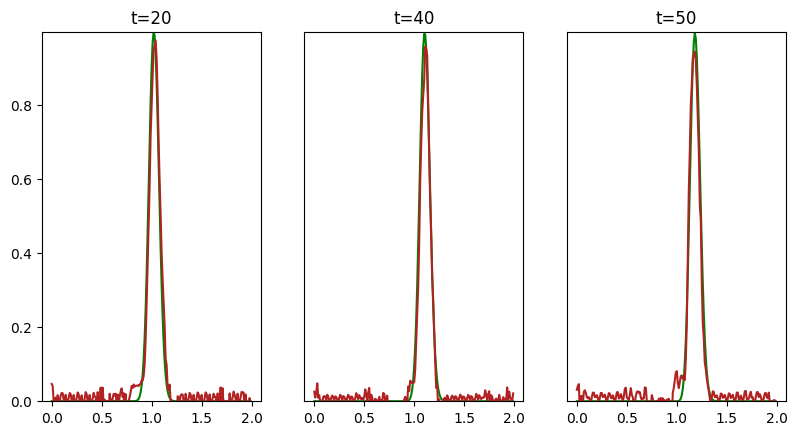

In [12]:
#Plotting the comparison plots

idx = np.random.randint(0,ntest) 
x_range = x_disc

u_field_actual = test_u[idx]
u_field_pred = pred_set[idx]

v_min = torch.min(u_field_actual)
v_max = torch.max(u_field_actual)


fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1,3,1)
pcm = ax.plot(x_range, u_field_actual[0,:], color='green')
pcm = ax.plot(x_range, u_field_pred[0,:], color='firebrick')
ax.set_ylim([v_min, v_max])
ax.title.set_text('t='+ str(T_in))

u_field_actual = test_u[idx]
u_field_pred = pred_set[idx]

ax = fig.add_subplot(1,3,2)
pcm = ax.plot(x_range, u_field_actual[int(T/2),:], color='green')
pcm = ax.plot(x_range, u_field_pred[int(T/2),:], color='firebrick')
ax.set_ylim([v_min, v_max])
ax.title.set_text('t='+ str(int((T+(T_in/2)))))
ax.axes.yaxis.set_ticks([])

ax = fig.add_subplot(1,3,3)
pcm = ax.plot(x_range, u_field_actual[-1,:], color='green')
pcm = ax.plot(x_range, u_field_pred[-1,:], color='firebrick')
ax.title.set_text('t='+str(T+T_in))
ax.set_ylim([v_min, v_max])
ax.axes.yaxis.set_ticks([])


# output_plot = (file_loc + '/Plots/_Unet_CP_' + run_name + '_' + str(gamma)+'.png')
# plt.savefig(output_plot)

In [13]:
CODE = ['Advection_UNet.py']
# INPUTS = []
# OUTPUTS = [model_loc, output_plot[0], output_plot[1], output_plot[2]]

## Save code files
#for code_file in CODE:
#    if os.path.isfile(code_file):
#        run.save(code_file, 'code')
#    elif os.path.isdir(code_file):
#        run.save_directory(code_file, 'code', 'text/plain', preserve_path=True)
#    else:
#        print('ERROR: code file %s does not exist' % code_file)


## Save input files
#for input_file in INPUTS:
#    if os.path.isfile(input_file):
#        run.save(input_file, 'input')
#    elif os.path.isdir(input_file):
#        run.save_directory(input_file, 'input', 'text/plain', preserve_path=True)
#    else:
#        print('ERROR: input file %s does not exist' % input_file)


## Save output files
#for output_file in OUTPUTS:
#    if os.path.isfile(output_file):
#        run.save(output_file, 'output')
#    elif os.path.isdir(output_file):
#        run.save_directory(output_file, 'output', 'text/plain', preserve_path=True)   
#    else:
#        print('ERROR: output file %s does not exist' % output_file)

#run.close()

In [14]:
#Testing for a single simulation prediction only
#Residual Estimations across the spatio-temporal tensor
idx = 10
t_pred = t_disc[T_in:T_in+T_out]
u_actual = test_u[idx].numpy()
u_pred = pred_set[idx].numpy()
u_mae = np.abs(u_actual - u_pred)

u_t = np.gradient(u_pred, dt, axis=0)
u_x = np.gradient(u_pred, dx, axis=1)
u_residual = u_t + v[80+idx]*u_x 

grads = np.gradient(u_pred, dt, dx)
u_residual = grads[0][:, :] + v[80+idx]*grads[1][:, :]

In [15]:
#Testing for a single simulation prediction only
#Residual Estimations across the spatio-temporal tensor
idx = 10
t_pred = t_disc[T_in:T_in+T_out]
u_actual = test_u[idx].numpy()
u_pred = pred_set[idx].numpy()
u_mae = np.abs(u_actual - u_pred)

u_t = np.gradient(u_pred, dt, axis=0)
u_x = np.gradient(u_pred, dx, axis=1)
u_residual_1 = u_t + v[80+idx]*u_x 

grads = np.gradient(u_pred, dt, dx)
u_residual = grads[0][:, :] + v[80+idx]*grads[1][:, :]

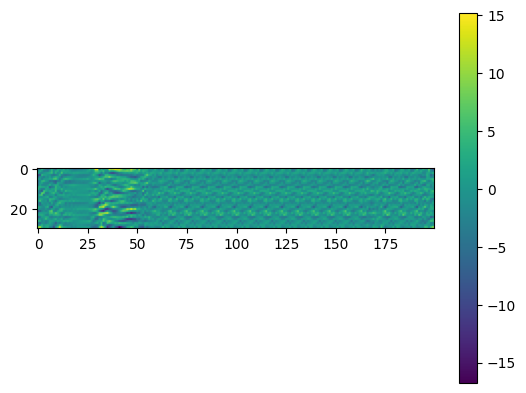

In [16]:
plt.imshow(u_residual)
plt.colorbar()

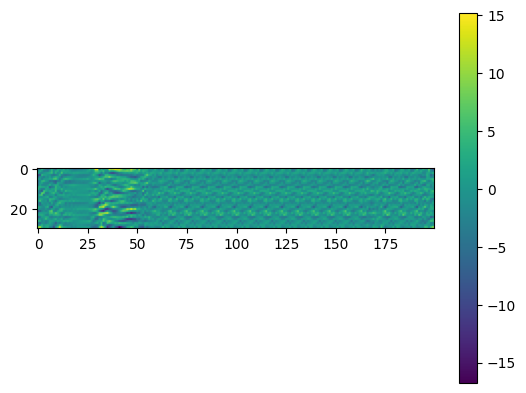

In [17]:
plt.imshow(u_residual_1)
plt.colorbar()

In [18]:
grads = np.gradient(pred_set, dt, dx, axis=[1,2])


In [19]:
len(grads)

2

In [20]:
grads[0].shape

(20, 30, 200)

In [21]:
grads[0][idx, :, :] + v[80+idx]*grads[1][idx, :, :]


array([[-6.088427  , -4.303234  ,  5.220595  , ...,  8.824248  ,
        -4.2714057 , -9.152667  ],
       [-3.231354  ,  3.015776  ,  0.5504239 , ...,  4.617938  ,
        -2.1720529 , -2.3887239 ],
       [ 3.1049452 , -1.2569342 , -1.9038777 , ...,  1.8588748 ,
         0.44743693,  3.797453  ],
       ...,
       [-3.7657979 , -6.196617  , -1.0803379 , ...,  1.5245713 ,
        -2.4519863 , -2.468389  ],
       [-2.7790704 , -0.5638756 ,  3.740291  , ...,  0.02451336,
        -1.7864016 ,  0.1659767 ],
       [ 9.760983  , 11.844132  ,  4.451464  , ..., -0.63789713,
         5.8678827 ,  9.084525  ]], dtype=float32)

In [22]:
u_residual = grads[0][idx, :, :] + v[80+idx]*grads[1][idx, :, :]


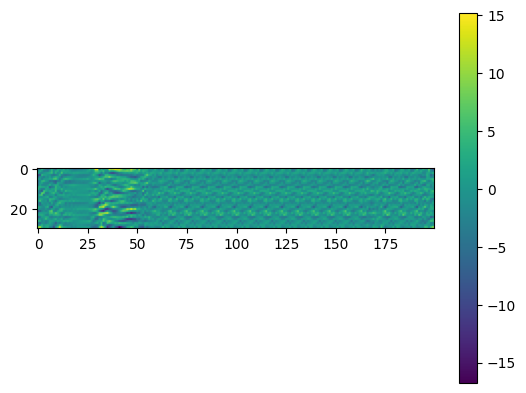

In [23]:
plt.imshow(u_residual)
plt.colorbar()

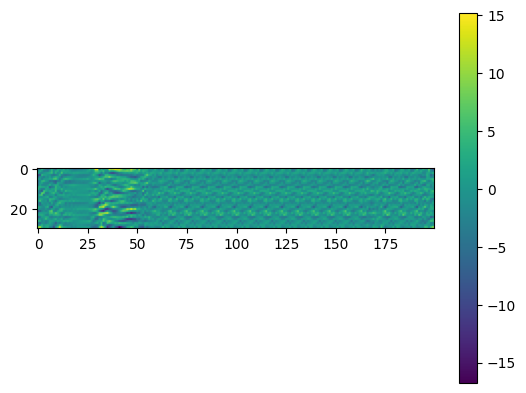

In [24]:
#For all the test sims
grads = np.gradient(pred_set, dt, dx, axis=[1,2])
u_residual = grads[0][idx, :, :] + v[80+idx]*grads[1][idx, :, :]

plt.imshow(u_residual)
plt.colorbar()

In [25]:
#Testing for a single simulation prediction only
#Residual Estimations across the spatio-temporal tensor
idx = 10
t_pred = t_disc[T_in:T_in+T_out]
u_actual = test_u[idx].numpy()
u_pred = pred_set[idx].numpy()
u_mae = np.abs(u_actual - u_pred)

u_t = np.gradient(u_pred, dt, axis=0)
u_x = np.gradient(u_pred, dx, axis=1)
u_residual_1 = u_t + v[80+idx]*u_x 

grads = np.gradient(u_pred, dt, dx, edge_order=2, axis=[1,2])
u_residual = grads[0][:, :] + v[80+idx]*grads[1][:, :]

AxisError: axis 2 is out of bounds for array of dimension 2

In [26]:
#Testing for a single simulation prediction only
#Residual Estimations across the spatio-temporal tensor
idx = 10
t_pred = t_disc[T_in:T_in+T_out]
u_actual = test_u[idx].numpy()
u_pred = pred_set[idx].numpy()
u_mae = np.abs(u_actual - u_pred)

u_t = np.gradient(u_pred, dt, edge_order=2, axis=0)
u_x = np.gradient(u_pred, dx, axis=1)
u_residual_1 = u_t + v[80+idx]*u_x 

grads = np.gradient(u_pred, dt, dx, axis=[1,2])
u_residual = grads[0][:, :] + v[80+idx]*grads[1][:, :]

AxisError: axis 2 is out of bounds for array of dimension 2

In [27]:
u_t = np.gradient(u_pred, dt, edge_order=2, axis=0)


In [28]:
u_t = np.gradient(u_pred, dt, edge_order=2, axis=0)
u_x = np.gradient(u_pred, dx, edge_order=2, axis=1)
u_residual_1 = u_t + v[80+idx]*u_x 

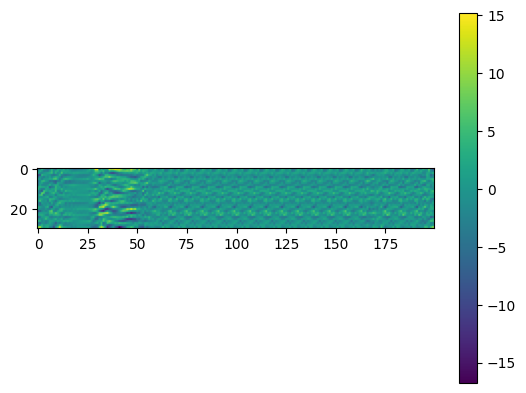

In [29]:
plt.imshow(u_residual)
plt.colorbar()

In [30]:
plt.imshow(u_residual_1)
plt.colorbar()

In [31]:
plt.imshow(u_mae)
plt.colorbar()

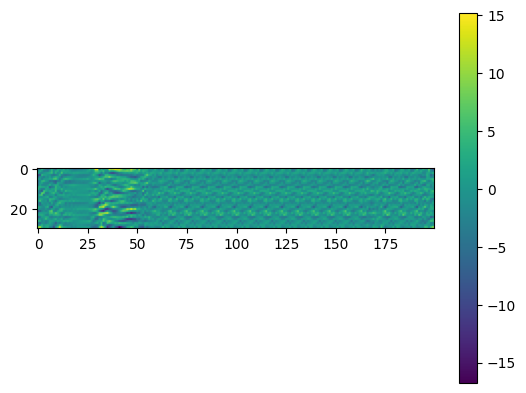

In [32]:
plt.imshow(u_residual)
plt.colorbar()

In [33]:
#Test Plots
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(2,3,1)
pcm =ax.imshow(u_mae, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
# ax.title.set_text('Initial')
ax.title.set_text('t='+ str(T_in))
ax.set_ylabel('Solution')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0)

SyntaxError: unexpected EOF while parsing (<ipython-input-33-d4a66bf60fbf>, line 14)

In [34]:
#Test Plots
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(2,3,1)
pcm =ax.imshow(u_mae, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
# ax.title.set_text('Initial')
ax.title.set_text('t='+ str(T_in))
ax.set_ylabel('Solution')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))

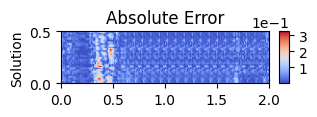

In [35]:
#Test Plots
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(2,3,1)
pcm =ax.imshow(u_mae, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
# ax.title.set_text('Initial')
ax.title.set_text('Absolute Error')
ax.set_ylabel('Solution')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))

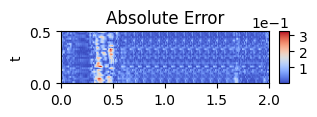

In [36]:
#Test Plots
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(2,3,1)
pcm =ax.imshow(u_mae, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
# ax.title.set_text('Initial')
ax.title.set_text('Absolute Error')
ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))

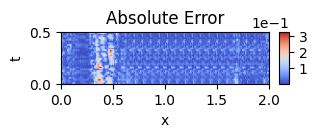

In [37]:
#Test Plots
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1,3,1)
pcm =ax.imshow(u_mae, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('Absolute Error')
ax.set_xlabel('x')
ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))

AxisError: axis 2 is out of bounds for array of dimension 2

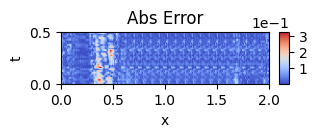

In [38]:
#Test Plots
from mpl_toolkits.axes_grid1 import make_axes_locatable

idx = 10
u_actual = test_u[idx].numpy()
u_pred = pred_set[idx].numpy()
u_mae = np.abs(u_actual - u_pred)


fig = plt.figure(figsize=(10, 6))

ax = fig.add_subplot(1,3,1)
pcm =ax.imshow(u_mae, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('Abs Error')
ax.set_xlabel('x')
ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))


#First order residual 
grads = np.gradient(u_pred, dt, dx, edge_order=2, axis=[1,2])
u_residual = grads[0][:, :] + v[80+idx]*grads[1][:, :]

ax = fig.add_subplot(1,3,2)
pcm =ax.imshow(u_residual, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('1st Order Residual')
ax.set_xlabel('x')
ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))

AxisError: axis 2 is out of bounds for array of dimension 2

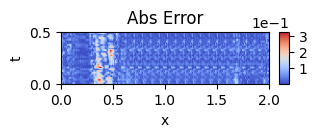

In [39]:
#Test Plots
from mpl_toolkits.axes_grid1 import make_axes_locatable

idx = 10
u_actual = test_u[idx].numpy()
u_pred = pred_set[idx].numpy()
u_mae = np.abs(u_actual - u_pred)


fig = plt.figure(figsize=(10, 6))

ax = fig.add_subplot(1,3,1)
pcm =ax.imshow(u_mae, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('Abs Error')
ax.set_xlabel('x')
ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))


#First order residual 
grads = np.gradient(u_pred, dt, dx, edge_order=1, axis=[1,2])
u_residual = grads[0][:, :] + v[80+idx]*grads[1][:, :]

ax = fig.add_subplot(1,3,2)
pcm =ax.imshow(u_residual, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('1st Order Residual')
ax.set_xlabel('x')
ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))

AxisError: axis 2 is out of bounds for array of dimension 2

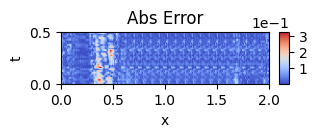

In [40]:
#Test Plots
from mpl_toolkits.axes_grid1 import make_axes_locatable

idx = 10
u_actual = test_u[idx].numpy()
u_pred = pred_set[idx].numpy()
u_mae = np.abs(u_actual - u_pred)


fig = plt.figure(figsize=(10, 6))

ax = fig.add_subplot(1,3,1)
pcm =ax.imshow(u_mae, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('Abs Error')
ax.set_xlabel('x')
ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))


#First order residual 
grads = np.gradient(u_pred, dt, dx, axis=[1,2])
u_residual = grads[0][:, :] + v[80+idx]*grads[1][:, :]

ax = fig.add_subplot(1,3,2)
pcm =ax.imshow(u_residual, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('1st Order Residual')
ax.set_xlabel('x')
ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))

In [41]:
u_pred

array([[ 0.0660246 , -0.03461411, -0.035414  , ...,  0.01282363,
         0.0882832 ,  0.01523552],
       [ 0.04102312, -0.05832763,  0.0075464 , ...,  0.07309356,
         0.04948352, -0.04551252],
       [ 0.06668634,  0.02958073, -0.03922422, ...,  0.06803617,
         0.08429989,  0.02848615],
       ...,
       [ 0.11344656,  0.01858363, -0.06634576, ..., -0.03620376,
         0.03803263,  0.07451355],
       [ 0.01032701, -0.09694878, -0.06176439, ..., -0.03505922,
        -0.03995092, -0.00633467],
       [ 0.12694186,  0.02977672, -0.00903603, ..., -0.0470238 ,
        -0.00262657,  0.05759677]], dtype=float32)

In [42]:
u_pred.shape

(30, 200)

In [43]:
grads = np.gradient(u_pred, dt, dx, axis=[1,2])


AxisError: axis 2 is out of bounds for array of dimension 2

In [44]:
#Testing for a single simulation prediction only
#Residual Estimations across the spatio-temporal tensor
idx = 10
t_pred = t_disc[T_in:T_in+T_out]
u_actual = test_u[idx].numpy()
u_pred = pred_set[idx].numpy()
u_mae = np.abs(u_actual - u_pred)

u_t = np.gradient(u_pred, dt, edge_order=2, axis=0)
u_x = np.gradient(u_pred, dx, edge_order=2, axis=1)
u_residual_1 = u_t + v[80+idx]*u_x 

grads = np.gradient(u_pred, dt, dx, axis=[1,2])
u_residual = grads[0][:, :] + v[80+idx]*grads[1][:, :]

AxisError: axis 2 is out of bounds for array of dimension 2

In [45]:
grads = np.gradient(pred_set, dt, dx, axis=[1,2]) #Estimating gradients across the batch 


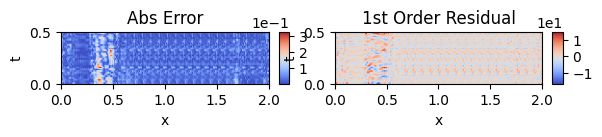

In [46]:
#Test Plots
from mpl_toolkits.axes_grid1 import make_axes_locatable

idx = 10
u_actual = test_u[idx].numpy()
u_pred = pred_set[idx].numpy()
u_mae = np.abs(u_actual - u_pred)


fig = plt.figure(figsize=(10, 6))

ax = fig.add_subplot(1,3,1)
pcm =ax.imshow(u_mae, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('Abs Error')
ax.set_xlabel('x')
ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))


#First order residual 
grads = np.gradient(u_pred, dt, dx, axis=[0,1])
u_residual = grads[0][:, :] + v[80+idx]*grads[1][:, :]

ax = fig.add_subplot(1,3,2)
pcm =ax.imshow(u_residual, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('1st Order Residual')
ax.set_xlabel('x')
ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))

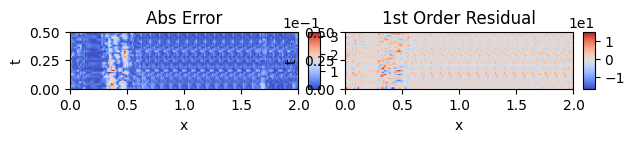

In [47]:
#Test Plots
from mpl_toolkits.axes_grid1 import make_axes_locatable

idx = 10
u_actual = test_u[idx].numpy()
u_pred = pred_set[idx].numpy()
u_mae = np.abs(u_actual - u_pred)


fig = plt.figure(figsize=(10, 6))
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.1, hspace=0.1)

ax = fig.add_subplot(1,3,1)
pcm =ax.imshow(u_mae, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('Abs Error')
ax.set_xlabel('x')
ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))


#First order residual 
grads = np.gradient(u_pred, dt, dx, axis=[0,1])
u_residual = grads[0][:, :] + v[80+idx]*grads[1][:, :]

ax = fig.add_subplot(1,3,2)
pcm =ax.imshow(u_residual, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('1st Order Residual')
ax.set_xlabel('x')
ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))

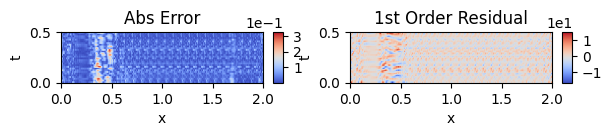

In [48]:
#Test Plots
from mpl_toolkits.axes_grid1 import make_axes_locatable

idx = 10
u_actual = test_u[idx].numpy()
u_pred = pred_set[idx].numpy()
u_mae = np.abs(u_actual - u_pred)


fig = plt.figure(figsize=(10, 6))
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.3, hspace=0.1)

ax = fig.add_subplot(1,3,1)
pcm =ax.imshow(u_mae, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('Abs Error')
ax.set_xlabel('x')
ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))


#First order residual 
grads = np.gradient(u_pred, dt, dx, axis=[0,1])
u_residual = grads[0][:, :] + v[80+idx]*grads[1][:, :]

ax = fig.add_subplot(1,3,2)
pcm =ax.imshow(u_residual, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('1st Order Residual')
ax.set_xlabel('x')
ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))

In [49]:
#Test Plots
from mpl_toolkits.axes_grid1 import make_axes_locatable

idx = 10
u_actual = test_u[idx].numpy()
u_pred = pred_set[idx].numpy()
u_mae = np.abs(u_actual - u_pred)


fig = plt.figure(figsize=(10, 6))
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.5, hspace=0.1)

ax = fig.add_subplot(1,3,1)
pcm =ax.imshow(u_mae, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('Abs Error')
ax.set_xlabel('x')
ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))


#First order residual 
grads = np.gradient(u_pred, dt, dx, axis=[0,1])
u_residual = grads[0][:, :] + v[80+idx]*grads[1][:, :]

ax = fig.add_subplot(1,3,2)
pcm =ax.imshow(u_residual, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('1st Order Residual')
ax.set_xlabel('x')
ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))

In [50]:
#Test Plots
from mpl_toolkits.axes_grid1 import make_axes_locatable

idx = 10
u_actual = test_u[idx].numpy()
u_pred = pred_set[idx].numpy()
u_mae = np.abs(u_actual - u_pred)


fig = plt.figure(figsize=(10, 6))
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.5, hspace=0.1)

ax = fig.add_subplot(1,3,1)
pcm =ax.imshow(u_mae, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('Abs Error')
ax.set_xlabel('x')
ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))


#First order residual 
grads = np.gradient(u_pred, dt, dx, axis=[0,1])
u_residual = grads[0][:, :] + v[80+idx]*grads[1][:, :]

ax = fig.add_subplot(1,3,2)
pcm =ax.imshow(u_residual, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('1st Order Residual')
ax.set_xlabel('x')
# ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))

In [51]:
#Test Plots
from mpl_toolkits.axes_grid1 import make_axes_locatable

idx = 10
u_actual = test_u[idx].numpy()
u_pred = pred_set[idx].numpy()
u_mae = np.abs(u_actual - u_pred)


fig = plt.figure(figsize=(10, 6))
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.5, hspace=0.1)

ax = fig.add_subplot(1,3,1)
pcm =ax.imshow(u_mae, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('Abs Error')
ax.set_xlabel('x')
ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))


#First order residual 
grads = np.gradient(u_pred, dt, dx, axis=[0,1])
u_residual = grads[0][:, :] + v[80+idx]*grads[1][:, :]

ax = fig.add_subplot(1,3,2)
pcm =ax.imshow(u_residual, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('1st Order Residual')
ax.set_xlabel('x')
# ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))


#Second Order FD 
grads = np.gradient(u_pred, dt, dx, edge_order=2, axis=[0,1])
u_residual = grads[0][:, :] + v[80+idx]*grads[1][:, :]

ax = fig.add_subplot(1,3,2)
pcm =ax.imshow(u_residual, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('1st Order Residual')
ax.set_xlabel('x')
# ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))

In [52]:
#Test Plots
from mpl_toolkits.axes_grid1 import make_axes_locatable

idx = 10
u_actual = test_u[idx].numpy()
u_pred = pred_set[idx].numpy()
u_mae = np.abs(u_actual - u_pred)


fig = plt.figure(figsize=(10, 6))
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.5, hspace=0.1)

ax = fig.add_subplot(1,3,1)
pcm =ax.imshow(u_mae, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('Abs Error')
ax.set_xlabel('x')
ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))


#First order residual 
grads = np.gradient(u_pred, dt, dx, axis=[0,1])
u_residual = grads[0][:, :] + v[80+idx]*grads[1][:, :]

ax = fig.add_subplot(1,3,2)
pcm =ax.imshow(u_residual, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('1st Order Residual')
ax.set_xlabel('x')
# ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))


#Second Order FD 
grads = np.gradient(u_pred, dt, dx, edge_order=2, axis=[0,1])
u_residual = grads[0][:, :] + v[80+idx]*grads[1][:, :]

ax = fig.add_subplot(1,3,3)
pcm =ax.imshow(u_residual, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('2nd Order FD')
ax.set_xlabel('x')
# ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))

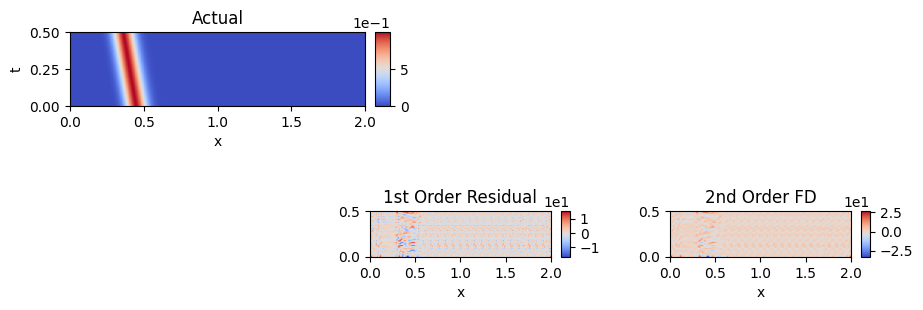

In [53]:
#Test Plots
from mpl_toolkits.axes_grid1 import make_axes_locatable

idx = 10
u_actual = test_u[idx].numpy()
u_pred = pred_set[idx].numpy()
u_mae = np.abs(u_actual - u_pred)


fig = plt.figure(figsize=(10, 6))
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.5, hspace=0.1)

ax = fig.add_subplot(3,2,1)
pcm =ax.imshow(u_actual, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('Actual')
ax.set_xlabel('x')
ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))


#First order residual 
grads = np.gradient(u_pred, dt, dx, axis=[0,1])
u_residual = grads[0][:, :] + v[80+idx]*grads[1][:, :]

ax = fig.add_subplot(1,3,2)
pcm =ax.imshow(u_residual, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('1st Order Residual')
ax.set_xlabel('x')
# ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))


#Second Order FD 
grads = np.gradient(u_pred, dt, dx, edge_order=2, axis=[0,1])
u_residual = grads[0][:, :] + v[80+idx]*grads[1][:, :]

ax = fig.add_subplot(1,3,3)
pcm =ax.imshow(u_residual, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('2nd Order FD')
ax.set_xlabel('x')
# ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))

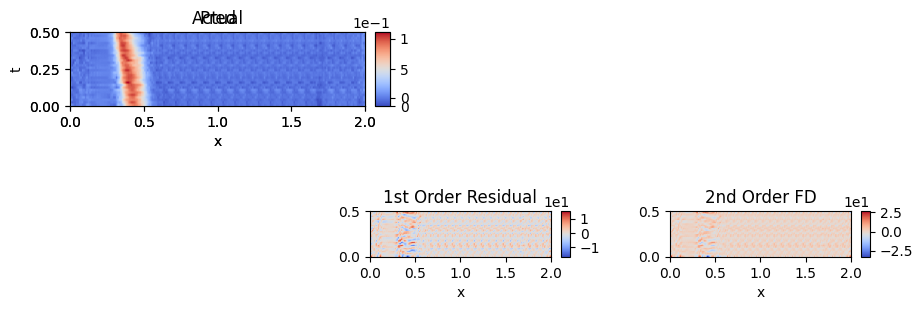

In [54]:
#Test Plots
from mpl_toolkits.axes_grid1 import make_axes_locatable

idx = 10
u_actual = test_u[idx].numpy()
u_pred = pred_set[idx].numpy()
u_mae = np.abs(u_actual - u_pred)


fig = plt.figure(figsize=(10, 6))
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.5, hspace=0.1)

ax = fig.add_subplot(3,2,1)
pcm =ax.imshow(u_actual, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('Actual')
ax.set_xlabel('x')
ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))

ax = fig.add_subplot(3,2,1)
pcm =ax.imshow(u_pred, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('Pred')
ax.set_xlabel('x')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))

#First order residual 
grads = np.gradient(u_pred, dt, dx, axis=[0,1])
u_residual = grads[0][:, :] + v[80+idx]*grads[1][:, :]

ax = fig.add_subplot(1,3,2)
pcm =ax.imshow(u_residual, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('1st Order Residual')
ax.set_xlabel('x')
# ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))


#Second Order FD 
grads = np.gradient(u_pred, dt, dx, edge_order=2, axis=[0,1])
u_residual = grads[0][:, :] + v[80+idx]*grads[1][:, :]

ax = fig.add_subplot(1,3,3)
pcm =ax.imshow(u_residual, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('2nd Order FD')
ax.set_xlabel('x')
# ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))

In [55]:
#Test Plots
from mpl_toolkits.axes_grid1 import make_axes_locatable

idx = 10
u_actual = test_u[idx].numpy()
u_pred = pred_set[idx].numpy()
u_mae = np.abs(u_actual - u_pred)


fig = plt.figure(figsize=(10, 6))
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.5, hspace=0.1)

ax = fig.add_subplot(3,2,1)
pcm =ax.imshow(u_actual, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('Actual')
ax.set_xlabel('x')
ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))

ax = fig.add_subplot(3,2,2)
pcm =ax.imshow(u_pred, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('Pred')
ax.set_xlabel('x')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))

#First order residual 
grads = np.gradient(u_pred, dt, dx, axis=[0,1])
u_residual = grads[0][:, :] + v[80+idx]*grads[1][:, :]

ax = fig.add_subplot(3,2,3)
pcm =ax.imshow(u_residual, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('1st Order Residual')
ax.set_xlabel('x')
# ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))


#Second Order FD 
grads = np.gradient(u_pred, dt, dx, edge_order=2, axis=[0,1])
u_residual = grads[0][:, :] + v[80+idx]*grads[1][:, :]

ax = fig.add_subplot(1,3,3)
pcm =ax.imshow(u_residual, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('2nd Order FD')
ax.set_xlabel('x')
# ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))

In [56]:
#Test Plots
from mpl_toolkits.axes_grid1 import make_axes_locatable

idx = 10
u_actual = test_u[idx].numpy()
u_pred = pred_set[idx].numpy()
u_mae = np.abs(u_actual - u_pred)


fig = plt.figure(figsize=(10, 6))
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.5, hspace=0.1)

ax = fig.add_subplot(3,2,1)
pcm =ax.imshow(u_actual, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('Actual')
ax.set_xlabel('x')
ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))

ax = fig.add_subplot(3,2,2)
pcm =ax.imshow(u_pred, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('Pred')
ax.set_xlabel('x')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))

#First order FD
grads = np.gradient(u_pred, dt, dx, axis=[0,1])
u_residual = grads[0][:, :] + v[80+idx]*grads[1][:, :]

ax = fig.add_subplot(3,2,3)
pcm =ax.imshow(u_residual, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('1st Order FD')
ax.set_xlabel('x')
# ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))


#Second Order FD 
grads = np.gradient(u_pred, dt, dx, edge_order=2, axis=[0,1])
u_residual = grads[0][:, :] + v[80+idx]*grads[1][:, :]
ax = fig.add_subplot(3,2,4)
pcm =ax.imshow(u_residual, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('2nd Order FD')
ax.set_xlabel('x')
# ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))

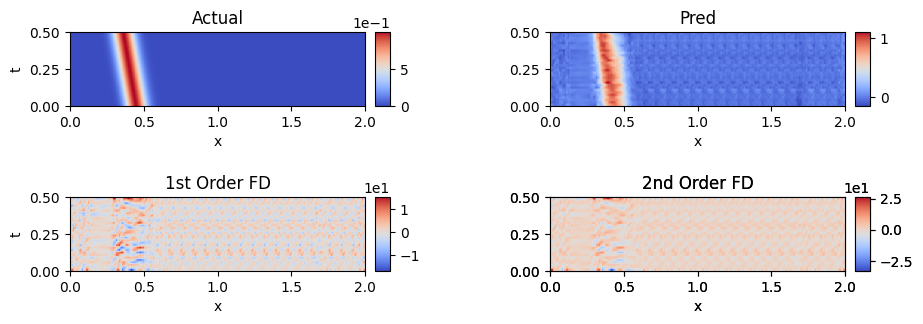

In [57]:
#Test Plots
from mpl_toolkits.axes_grid1 import make_axes_locatable

idx = 10
u_actual = test_u[idx].numpy()
u_pred = pred_set[idx].numpy()
u_mae = np.abs(u_actual - u_pred)


fig = plt.figure(figsize=(10, 6))
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.5, hspace=0.1)

ax = fig.add_subplot(3,2,1)
pcm =ax.imshow(u_actual, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('Actual')
ax.set_xlabel('x')
ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))

ax = fig.add_subplot(3,2,2)
pcm =ax.imshow(u_pred, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('Pred')
ax.set_xlabel('x')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))

#First order FD
grads = np.gradient(u_pred, dt, dx, axis=[0,1])
u_residual = grads[0][:, :] + v[80+idx]*grads[1][:, :]

ax = fig.add_subplot(3,2,3)
pcm =ax.imshow(u_residual, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('1st Order FD')
ax.set_xlabel('x')
ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))


#Second Order FD 
grads = np.gradient(u_pred, dt, dx, edge_order=2, axis=[0,1])
u_residual = grads[0][:, :] + v[80+idx]*grads[1][:, :]
ax = fig.add_subplot(3,2,4)
pcm =ax.imshow(u_residual, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('2nd Order FD')
ax.set_xlabel('x')
# ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))


#Absolute Error 
grads = np.gradient(u_pred, dt, dx, edge_order=2, axis=[0,1])
u_residual = grads[0][:, :] + v[80+idx]*grads[1][:, :]
ax = fig.add_subplot(3,2,4)
pcm =ax.imshow(u_residual, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('2nd Order FD')
ax.set_xlabel('x')
# ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))

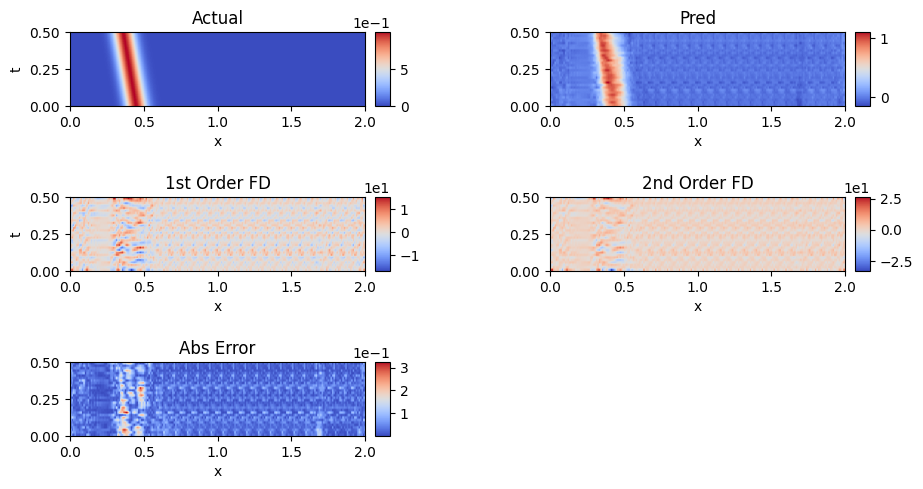

In [58]:
#Test Plots
from mpl_toolkits.axes_grid1 import make_axes_locatable

idx = 10
u_actual = test_u[idx].numpy()
u_pred = pred_set[idx].numpy()
u_mae = np.abs(u_actual - u_pred)


fig = plt.figure(figsize=(10, 6))
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.5, hspace=0.1)

ax = fig.add_subplot(3,2,1)
pcm =ax.imshow(u_actual, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('Actual')
ax.set_xlabel('x')
ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))

ax = fig.add_subplot(3,2,2)
pcm =ax.imshow(u_pred, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('Pred')
ax.set_xlabel('x')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))

#First order FD
grads = np.gradient(u_pred, dt, dx, axis=[0,1])
u_residual = grads[0][:, :] + v[80+idx]*grads[1][:, :]

ax = fig.add_subplot(3,2,3)
pcm =ax.imshow(u_residual, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('1st Order FD')
ax.set_xlabel('x')
ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))


#Second Order FD 
grads = np.gradient(u_pred, dt, dx, edge_order=2, axis=[0,1])
u_residual = grads[0][:, :] + v[80+idx]*grads[1][:, :]
ax = fig.add_subplot(3,2,4)
pcm =ax.imshow(u_residual, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('2nd Order FD')
ax.set_xlabel('x')
# ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))


#Absolute Error 
grads = np.gradient(u_pred, dt, dx, edge_order=2, axis=[0,1])
u_residual = grads[0][:, :] + v[80+idx]*grads[1][:, :]
ax = fig.add_subplot(3,2,5)
pcm =ax.imshow(u_mae, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('Abs Error')
ax.set_xlabel('x')
# ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))

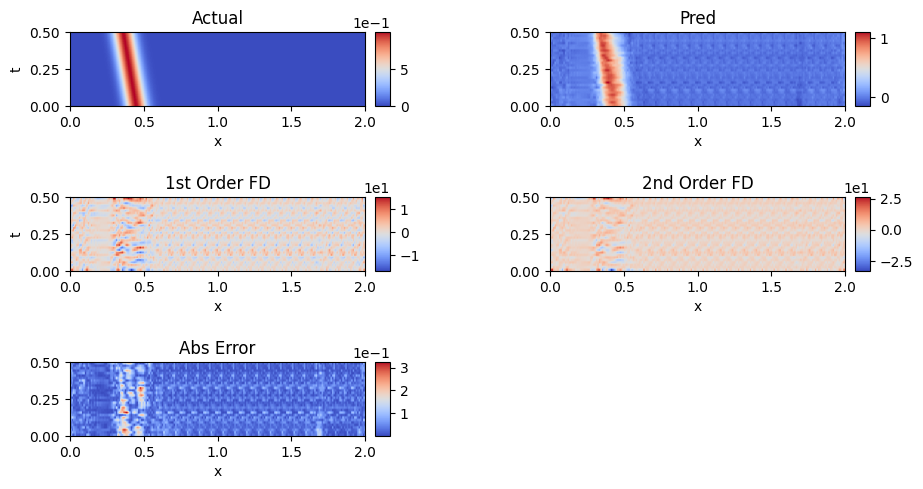

In [59]:
#Test Plots
from mpl_toolkits.axes_grid1 import make_axes_locatable

idx = 10
u_actual = test_u[idx].numpy()
u_pred = pred_set[idx].numpy()
u_mae = np.abs(u_actual - u_pred)
u_mse = (u_actual - u_pred)**2


fig = plt.figure(figsize=(10, 6))
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.5, hspace=0.1)

ax = fig.add_subplot(3,2,1)
pcm =ax.imshow(u_actual, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('Actual')
ax.set_xlabel('x')
ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))

ax = fig.add_subplot(3,2,2)
pcm =ax.imshow(u_pred, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('Pred')
ax.set_xlabel('x')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))

#First order FD
grads = np.gradient(u_pred, dt, dx, axis=[0,1])
u_residual = grads[0][:, :] + v[80+idx]*grads[1][:, :]

ax = fig.add_subplot(3,2,3)
pcm =ax.imshow(u_residual, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('1st Order FD')
ax.set_xlabel('x')
ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))


#Second Order FD 
grads = np.gradient(u_pred, dt, dx, edge_order=2, axis=[0,1])
u_residual = grads[0][:, :] + v[80+idx]*grads[1][:, :]
ax = fig.add_subplot(3,2,4)
pcm =ax.imshow(u_residual, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('2nd Order FD')
ax.set_xlabel('x')
# ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))


#Absolute Error 
grads = np.gradient(u_pred, dt, dx, edge_order=2, axis=[0,1])
u_residual = grads[0][:, :] + v[80+idx]*grads[1][:, :]
ax = fig.add_subplot(3,2,5)
pcm =ax.imshow(u_mae, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('Abs Error')
ax.set_xlabel('x')
# ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))

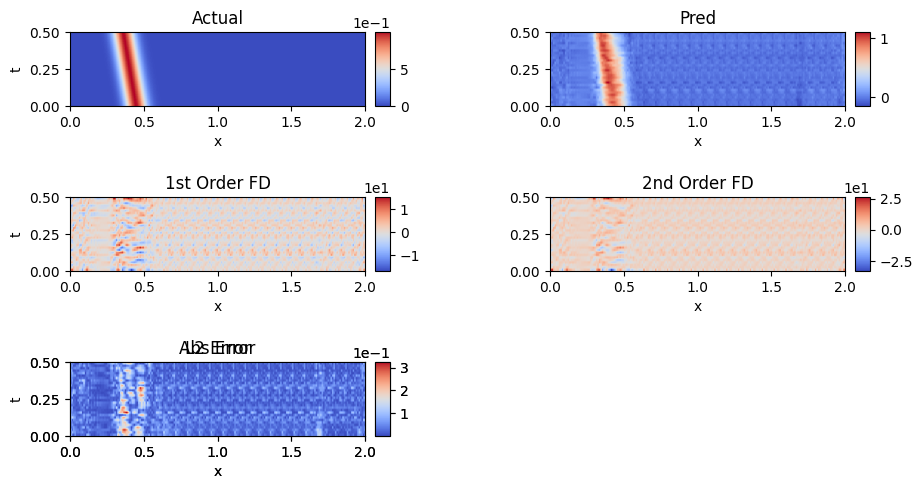

In [60]:
#Test Plots
from mpl_toolkits.axes_grid1 import make_axes_locatable

idx = 10
u_actual = test_u[idx].numpy()
u_pred = pred_set[idx].numpy()
u_mae = np.abs(u_actual - u_pred)
u_mse = (u_actual - u_pred)**2


fig = plt.figure(figsize=(10, 6))
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.5, hspace=0.1)

ax = fig.add_subplot(3,2,1)
pcm =ax.imshow(u_actual, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('Actual')
ax.set_xlabel('x')
ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))

ax = fig.add_subplot(3,2,2)
pcm =ax.imshow(u_pred, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('Pred')
ax.set_xlabel('x')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))

#First order FD
grads = np.gradient(u_pred, dt, dx, axis=[0,1])
u_residual = grads[0][:, :] + v[80+idx]*grads[1][:, :]

ax = fig.add_subplot(3,2,3)
pcm =ax.imshow(u_residual, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('1st Order FD')
ax.set_xlabel('x')
ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))


#Second Order FD 
grads = np.gradient(u_pred, dt, dx, edge_order=2, axis=[0,1])
u_residual = grads[0][:, :] + v[80+idx]*grads[1][:, :]
ax = fig.add_subplot(3,2,4)
pcm =ax.imshow(u_residual, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('2nd Order FD')
ax.set_xlabel('x')
# ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))


#Absolute Error 
grads = np.gradient(u_pred, dt, dx, edge_order=2, axis=[0,1])
u_residual = grads[0][:, :] + v[80+idx]*grads[1][:, :]
ax = fig.add_subplot(3,2,5)
pcm =ax.imshow(u_mae, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('Abs Error')
ax.set_xlabel('x')
ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))


#Squared Error 
grads = np.gradient(u_pred, dt, dx, edge_order=2, axis=[0,1])
u_residual = grads[0][:, :] + v[80+idx]*grads[1][:, :]
ax = fig.add_subplot(3,2,5)
pcm =ax.imshow(u_mae, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('L2 Error')
ax.set_xlabel('x')
# ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))

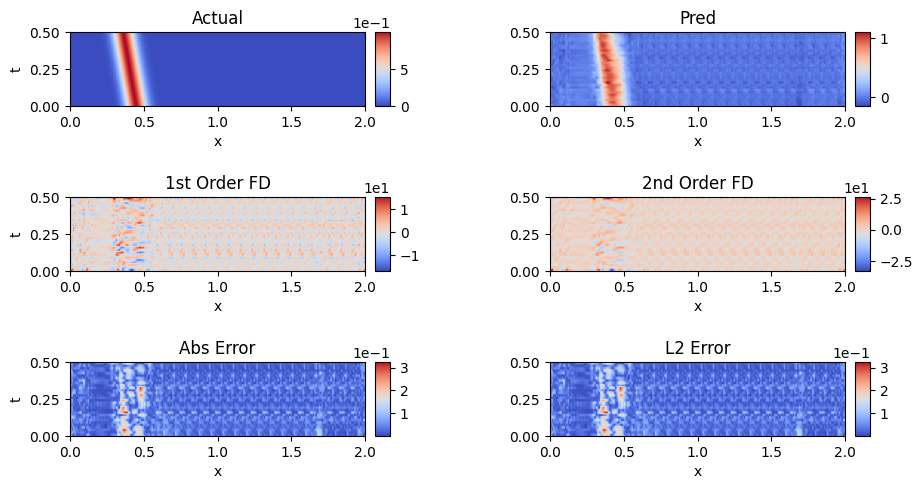

In [61]:
#Test Plots
from mpl_toolkits.axes_grid1 import make_axes_locatable

idx = 10
u_actual = test_u[idx].numpy()
u_pred = pred_set[idx].numpy()
u_mae = np.abs(u_actual - u_pred)
u_mse = (u_actual - u_pred)**2


fig = plt.figure(figsize=(10, 6))
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.5, hspace=0.1)

ax = fig.add_subplot(3,2,1)
pcm =ax.imshow(u_actual, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('Actual')
ax.set_xlabel('x')
ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))

ax = fig.add_subplot(3,2,2)
pcm =ax.imshow(u_pred, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('Pred')
ax.set_xlabel('x')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))

#First order FD
grads = np.gradient(u_pred, dt, dx, axis=[0,1])
u_residual = grads[0][:, :] + v[80+idx]*grads[1][:, :]

ax = fig.add_subplot(3,2,3)
pcm =ax.imshow(u_residual, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('1st Order FD')
ax.set_xlabel('x')
ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))


#Second Order FD 
grads = np.gradient(u_pred, dt, dx, edge_order=2, axis=[0,1])
u_residual = grads[0][:, :] + v[80+idx]*grads[1][:, :]
ax = fig.add_subplot(3,2,4)
pcm =ax.imshow(u_residual, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('2nd Order FD')
ax.set_xlabel('x')
# ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))


#Absolute Error 
grads = np.gradient(u_pred, dt, dx, edge_order=2, axis=[0,1])
u_residual = grads[0][:, :] + v[80+idx]*grads[1][:, :]
ax = fig.add_subplot(3,2,5)
pcm =ax.imshow(u_mae, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('Abs Error')
ax.set_xlabel('x')
ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))


#Squared Error 
grads = np.gradient(u_pred, dt, dx, edge_order=2, axis=[0,1])
u_residual = grads[0][:, :] + v[80+idx]*grads[1][:, :]
ax = fig.add_subplot(3,2,6)
pcm =ax.imshow(u_mae, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('L2 Error')
ax.set_xlabel('x')
# ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))

In [62]:
#Test Plots
from mpl_toolkits.axes_grid1 import make_axes_locatable

idx = 10
u_actual = test_u[idx].numpy()
u_pred = pred_set[idx].numpy()
u_mae = np.abs(u_actual - u_pred)
u_mse = (u_actual - u_pred)**2


fig = plt.figure(figsize=(10, 6))
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.5, hspace=0.1)

ax = fig.add_subplot(3,2,1)
pcm =ax.imshow(u_actual, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('Actual')
ax.set_xlabel('x')
ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))

ax = fig.add_subplot(3,2,2)
pcm =ax.imshow(u_pred, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('Pred')
ax.set_xlabel('x')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))

#First order FD
grads = np.gradient(u_pred, dt, dx, axis=[0,1])
u_residual = grads[0][:, :] + v[80+idx]*grads[1][:, :]

ax = fig.add_subplot(3,2,3)
pcm =ax.imshow(u_residual, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('1st Order FD')
ax.set_xlabel('x')
ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))


#Second Order FD 
grads = np.gradient(u_pred, dt, dx, edge_order=2, axis=[0,1])
u_residual = grads[0][:, :] + v[80+idx]*grads[1][:, :]

ax = fig.add_subplot(3,2,4)
pcm =ax.imshow(u_residual, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('2nd Order FD')
ax.set_xlabel('x')
# ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))


#Absolute Error 
ax = fig.add_subplot(3,2,5)
pcm =ax.imshow(u_mae, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('Abs Error')
ax.set_xlabel('x')
ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))


#Squared Error 

ax = fig.add_subplot(3,2,6)
pcm =ax.imshow(u_mse, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('L2 Error')
ax.set_xlabel('x')
# ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))

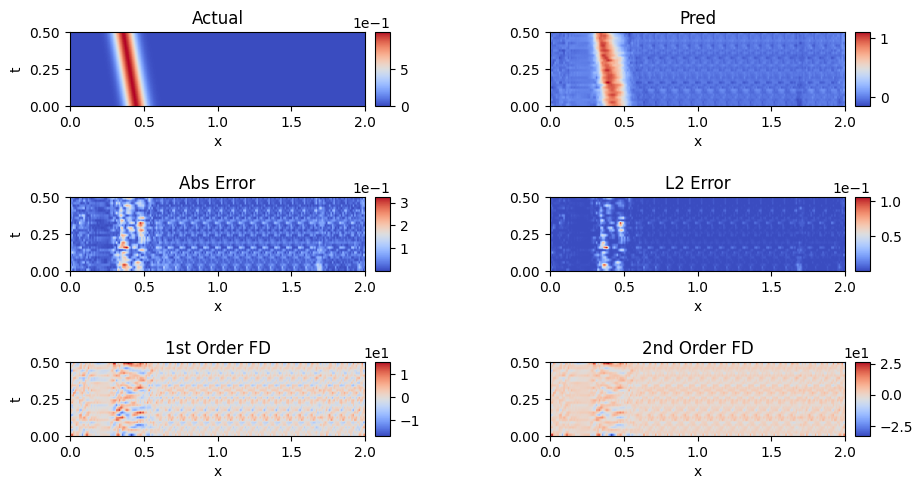

In [63]:
#Test Plots
from mpl_toolkits.axes_grid1 import make_axes_locatable

idx = 10
u_actual = test_u[idx].numpy()
u_pred = pred_set[idx].numpy()
u_mae = np.abs(u_actual - u_pred)
u_mse = (u_actual - u_pred)**2


fig = plt.figure(figsize=(10, 6))
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.5, hspace=0.1)

ax = fig.add_subplot(3,2,1)
pcm =ax.imshow(u_actual, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('Actual')
ax.set_xlabel('x')
ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))

ax = fig.add_subplot(3,2,2)
pcm =ax.imshow(u_pred, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('Pred')
ax.set_xlabel('x')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))

#First order FD
grads = np.gradient(u_pred, dt, dx, axis=[0,1])
u_residual = grads[0][:, :] + v[80+idx]*grads[1][:, :]

ax = fig.add_subplot(3,2,5)
pcm =ax.imshow(u_residual, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('1st Order FD')
ax.set_xlabel('x')
ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))


#Second Order FD 
grads = np.gradient(u_pred, dt, dx, edge_order=2, axis=[0,1])
u_residual = grads[0][:, :] + v[80+idx]*grads[1][:, :]

ax = fig.add_subplot(3,2,6)
pcm =ax.imshow(u_residual, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('2nd Order FD')
ax.set_xlabel('x')
# ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))


#Absolute Error 
ax = fig.add_subplot(3,2,3)
pcm =ax.imshow(u_mae, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('Abs Error')
ax.set_xlabel('x')
ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))


#Squared Error 
ax = fig.add_subplot(3,2,4)
pcm =ax.imshow(u_mse, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('L2 Error')
ax.set_xlabel('x')
# ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))

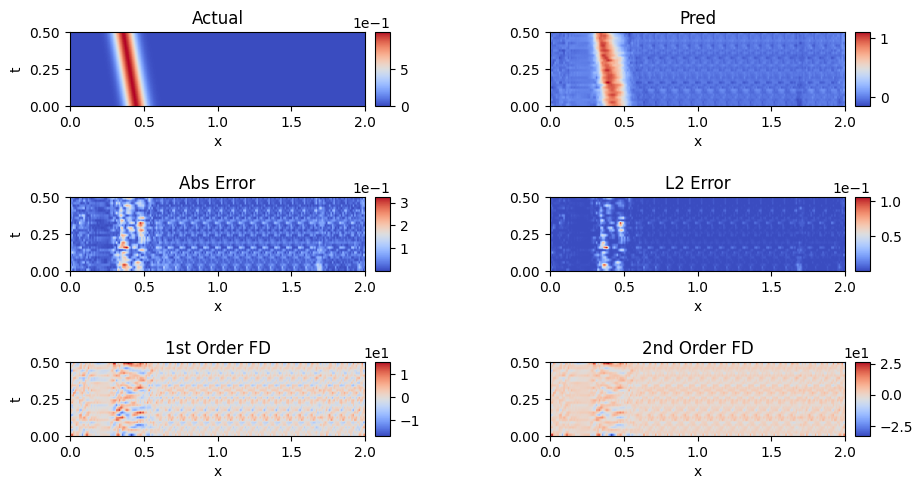

In [64]:
#Test Plots
from mpl_toolkits.axes_grid1 import make_axes_locatable

idx = 10
u_actual = test_u[idx].numpy()
u_pred = pred_set[idx].numpy()
u_mae = np.abs(u_actual - u_pred)
u_mse = (u_actual - u_pred)**2


fig = plt.figure(figsize=(10, 6))
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.5, hspace=0.1)

ax = fig.add_subplot(3,2,1)
pcm =ax.imshow(u_actual, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('Actual')
ax.set_xlabel('x')
ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))

ax = fig.add_subplot(3,2,2)
pcm =ax.imshow(u_pred, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('Pred')
ax.set_xlabel('x')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))


#Absolute Error 
ax = fig.add_subplot(3,2,3)
pcm =ax.imshow(u_mae, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('Abs Error')
ax.set_xlabel('x')
ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))


#Squared Error 
ax = fig.add_subplot(3,2,4)
pcm =ax.imshow(u_mse, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('L2 Error')
ax.set_xlabel('x')
# ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))

#First order FD
grads = np.gradient(u_pred, dt, dx, axis=[0,1])
u_residual = grads[0][:, :] + v[80+idx]*grads[1][:, :]

ax = fig.add_subplot(3,2,5)
pcm =ax.imshow(u_residual, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('1st Order FD')
ax.set_xlabel('x')
ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))

#Second Order FD 
grads = np.gradient(u_pred, dt, dx, edge_order=2, axis=[0,1])
u_residual = grads[0][:, :] + v[80+idx]*grads[1][:, :]

ax = fig.add_subplot(3,2,6)
pcm =ax.imshow(u_residual, cmap=cm.coolwarm, extent=[0.0, 2.0, 0, 0.5])
ax.title.set_text('2nd Order FD')
ax.set_xlabel('x')
# ax.set_ylabel('t')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.formatter.set_powerlimits((0, 0))